# Explainability of HEP events classification using SHAP
## Events classification using XGBoost
***

Raquel Pezoa, Luis Salinas, Claudio Torres (UV, CCTVal, UTFSM, Valparaíso Chile)


In [1]:
''' Needed Libraries '''
import shap
import xgboost
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from time import time
from matplotlib import pyplot as plt
import sys
import mplhep as hep
from scipy.special import expit 

sys.path.insert(0, '../scripts/')

''' Python code to measure performance '''
from performance import threshold_metrics

## Loading XGBoost classification model previously trained
***

- The model was generated using Python [XGboost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
- We performed hyperparameter tuning, obtaining the follwing parameters values:
 - {'eta': 0.005, 'objective': 'binary:logistic', 'subsample': 0.8, 'base_score': 0.5296727393261005, 'eval_metric': 'auc', 'max_depth': 2, 'tree_method': 'gpu_hist', 'min_child_weight': 5, 'colsample_bytree': 0.8}
- Training was performed in the [CCTVal cluster](http://www.hpc.utfsm.cl)




In [2]:
seed_=420
model = xgboost.Booster()
#model.load_model("../models/model_binary:logistic_logloss_md9_mcw9_ss0.6_cs0.8_eta0.005_nround10_g0.3.json")
model.load_model("2021-09-09-binlog_auc_model.json")

## Data
***
- Data is obtained from: https://www.openml.org/d/23512
- Each event is represented by a set of 28 features, including 21 low-level features corresponding to physics properties measured by the detector, and 7 high-level features derived from the previous ones.
- Some of the event's features:

|Type| Variable  | Description   |
|---| --- | --- |
|low-level|lepton pT |  Momentum of the lepton|
|low-level|lepton eta | Pseudorapidity eta of the lepton|
|low-level|lepton phi | Azimuthal angle phi of the lepton|
|low-level|Missing energy magnitude | Energy not detected|
|| ... | ...|
|high-level|m_jlv| Mass jet ($j$), lepton ($l$, electrons or muons), neutrino $\nu$| 
|high-level|m_bb| Mass quarks $b$|	
|high-level|m_wbb| Mass boson $W$ and quarks $b$|
|high-level|m_wwbb|Mass bosons $W$ and quarks $b$|



- More detailes in Baldi, P., Sadowski, P., & Whiteson, D. (2014). Searching for exotic particles in high-energy physics with deep learning. Nature communications, 5(1), 1-9 [(link)](https://www.nature.com/articles/ncomms5308).
- **Problem:** Binary classification of HEP events, to indentify signal from background.
 - signal: $gg \rightarrow H^0 \rightarrow W^{\mp} H^{\pm} \rightarrow W^{\mp} W^{\pm} h^0 \rightarrow W^{\mp} W^{\pm} b \bar{b}$. 
 This signal process is the fusion of two gluons into a heavy electrically neutral Higgs boson ($gg \rightarrow H^0 $), which decays to a heavy electrically-charged Higgs bosons ($H^{\pm}$) and a $W$ boson. The $H^{\pm}$ boson subsequently decays to a second $W$ boson and the light Higgs boson, $h^0$. The light Higgs boson decays predominantly to a pair of bottom quarks, giving the process.

## Reading data
*****

In [3]:
# Read data file
df = pd.read_csv("../data/higgs/phpZLgL9q.csv")
df.rename(columns = {'class': 'label'}, inplace = True)
# Removing last row containinng "?" values
df.drop(df.tail(1).index,inplace=True) # drop last n rows
df = df.apply(pd.to_numeric)
# Pandas dataframe for correlation matrix without label column
df_corr = df.drop('label', inplace=False, axis=1)

Columns (20,21,22,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
df.head()

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,...,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


###  Scaling data

In [5]:
# Scaling data

y = df["label"]
X = df.iloc[:,1:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
df_scaled = pd.DataFrame(scaled_data, columns=X.columns)

### Training, and testing sets

In [6]:
# Training, validation, and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=seed_)

# XGBoost format
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test,label=y_test)

In [7]:
X_train.shape

(78439, 28)

In [8]:
X_test.shape

(19610, 28)

## Prediction
***
- Prediction performed using the XGBoost classifier (model previously loaded) 

In [9]:
y_pred_test = model.predict(d_test)
y_pred_train = model.predict(d_train)

# Performance metrics
# Using different threshold values th to perform binary classification (prediction >= th --> signal, 
# prediction < th --> background) and getting classifier performance metrics
testing_list = threshold_metrics(y_test, y_pred_test, "loss", "metric", "xgboost")


Threshold: 0.1
Threshold: 0.2
Threshold: 0.30000000000000004
Threshold: 0.4
Threshold: 0.5
Threshold: 0.6
Threshold: 0.7000000000000001
Threshold: 0.8
Threshold: 0.9


In [10]:
testing_metrics_pd = pd.DataFrame(testing_list)
testing_metrics_pd


,th,F1,Prec,Rec,Acc,RocAuc
0,0.1,0.71,0.55,1.00,0.57,0.55
1,0.2,0.73,0.58,0.98,0.62,0.60
2,0.3,0.75,0.63,0.93,0.67,0.66
3,0.4,0.75,0.67,0.86,0.71,0.70
4,0.5,0.74,0.73,0.76,0.73,0.72
5,0.6,0.70,0.79,0.63,0.72,0.72
6,0.7,0.62,0.84,0.49,0.69,0.69
7,0.8,0.48,0.89,0.32,0.62,0.64
8,0.9,0.23,0.95,0.13,0.54,0.56


In [11]:
max_f1 = 0
for d in testing_list:
    print(d["F1"])
    if (d["F1"] > max_f1):
        max_f1 = d["F1"]
        sel_th = d["th"]
print("Selected th: ", sel_th)

0.71
0.73
0.75
0.75
0.74
0.7
0.62
0.48
0.23
Selected th:  0.30000000000000004


In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


fpr, tpr, ths = roc_curve(y_test,  y_pred_test)
auc_ = auc(fpr, tpr)
f1 = f1_score(y_test,  (y_pred_test>sel_th))
prec = precision_score(y_test,  (y_pred_test>sel_th))
rec = recall_score(y_test,  (y_pred_test>sel_th))
acc = accuracy_score(y_test,  (y_pred_test>sel_th))
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.75  -- prec: 0.63  -- recall: 0.93  -- acc: 0.67


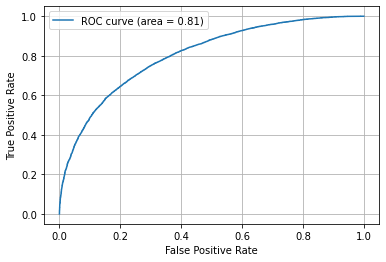

In [13]:
#create ROC curve
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

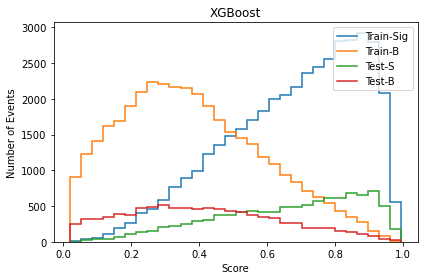

In [14]:
# Score distribution
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_signal_train, bins_sig_train = np.histogram(y_pred_train[y_train == 1], bins=30)
h_back_train, bins_back_train = np.histogram(y_pred_train[y_train == 0], bins=30)
h_sig_test, bins_sig_test = np.histogram(y_pred_test[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_test[y_test == 0], bins=30)

axs.set_title("XGBoost")
hep.histplot([h_signal_train,h_back_train, h_sig_test, h_back_test], bins_sig_test, 
             ax=axs,label=["Train-Sig", "Train-B", "Test-S", "Test-B"])
axs.legend()
axs.set_xlabel("Score")
axs.set_ylabel("Number of Events")

plt.tight_layout()
plt.show()

## SHAP
***
- SHAP can explain the output of any machine learning model
- Lundberg et al [1] developed a high-speed exact algorithm for tree ensemble methods.

[1] Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Proceedings of the 31st international conference on neural information processing systems. 2017.

In [15]:
import shap

In [16]:
# SHAP
start_time = time()
explainer = shap.TreeExplainer(model = model)
elapsed_time = time() - start_time
print("Elapsed time: %0.5f seconds." % elapsed_time)

Elapsed time: 4.94349 seconds.


In [17]:
start_time = time()
shap_values = explainer.shap_values(X_test)
elapsed_time = time() - start_time
print("Elapsed time: %0.5f seconds." % elapsed_time)


Elapsed time: 226.79627 seconds.


In [18]:
# print the JS visualization code to the notebook
shap.initjs()

### Waterfall plot
-  This plot show how  features contribute to push the classifier prediction from the base value (the average model prediction over the training dataset) to the model output, of an specific data sample.
- In this case, we are visualizing the SHAP values of the first sample of testing set (shap_values[0])
- Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. 
- We observe $m_{wbb}$ feature pushes lower (-0.76 SHAP value), and $m_{bb}$ feature pushes higher (+0.67 SHAP value).
- Model prediction $f(x)=-0.331$, and base value $E[f(x)]= 0.123$
- Notice that $f(x)$ and $E[f(x)]$ values correspond to values on the logit space.

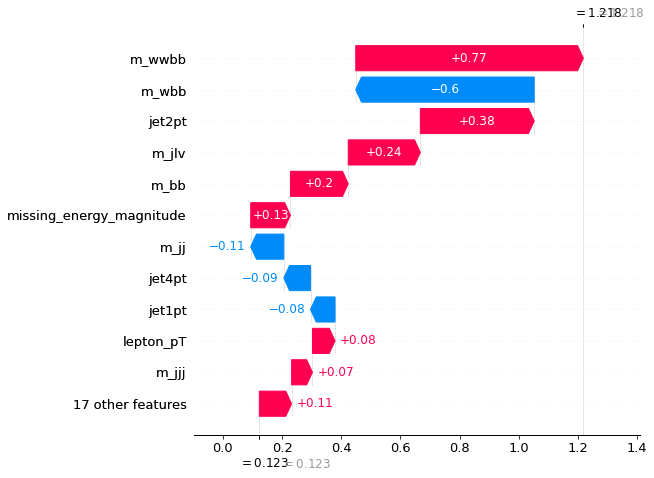

In [19]:
i=4
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, 
                                       shap_values[i],
                                       feature_names = df.columns[1:], 
                                       show = True,
                                      max_display=12)

In [20]:
print("SHAP Value m_wwwbb: %.3f" %shap_values[0,-2])
print("SHAP Value m_bb: %.3f" %shap_values[0,-3])

SHAP Value m_wwwbb: -0.760
SHAP Value m_bb: 0.671


###  Force plots
*****
- Showing features contribution of the first testing data sample on model prediction
- By default for binary classification the SHAP values are displayed in the logit space.
- Force plot supports link='logit' to transform log odds to probabilities.

In [21]:
# Force_plot
#  X_test.iloc[0,:] --> first testing data sample
shap.initjs()
sh = shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], link="logit")
display(sh)

Showing the force_plot as image
*****

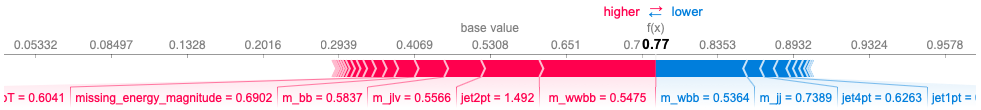

In [22]:
print("-- Sample's label:", y_test.iloc[i])
print("-- XGBoost prediction: %.2f" % y_pred_test[i])
print("-- Explainer expected value (logit space): %.4f" % explainer.expected_value)
print("-- XGboost prediction (logit space): %.4f" % (shap_values[i].sum() + explainer.expected_value))
print("-- XGboost prediction: %.4f" %expit(shap_values[i].sum() + explainer.expected_value))
print("-- Explainer expected value: %.4f" % expit(explainer.expected_value))
print("-- y_pred_test.mean(): %.4f" % y_pred_test.mean())

-- Sample's label: 1
-- XGBoost prediction: 0.77
-- Explainer expected value (logit space): 0.1234
-- XGboost prediction (logit space): 1.2176
-- XGboost prediction: 0.7716
-- Explainer expected value: 0.5308
-- y_pred_test.mean(): 0.5327


In [23]:
# Force_plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[102,:], X_test.iloc[102,:], link="logit")

Showing the force_plot as image
*****

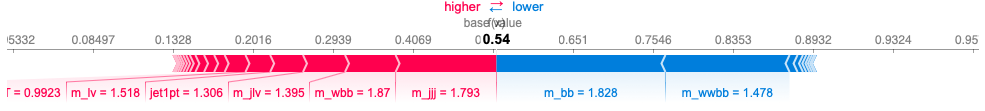

In [24]:
print("-- Sample's label:", y_test.iloc[102])
print("-- XGBoost prediction: %.2f" % y_pred_test[102])
print("-- Explainer expected value (logit space): %.4f" % explainer.expected_value)
print("-- XGboost prediction (logit space): %.4f" % (shap_values[102].sum() + explainer.expected_value))
print("-- XGboost prediction: %.4f" %expit(shap_values[102].sum() + explainer.expected_value))
print("-- Explainer expected value: %.4f" % expit(explainer.expected_value))
print("-- y_pred_train.mean(): %.4f" % y_pred_train.mean())

-- Sample's label: 1
-- XGBoost prediction: 0.54
-- Explainer expected value (logit space): 0.1234
-- XGboost prediction (logit space): 0.1452
-- XGboost prediction: 0.5362
-- Explainer expected value: 0.5308
-- y_pred_train.mean(): 0.5307


In [25]:
shap.force_plot(explainer.expected_value, shap_values[901,:], X_test.iloc[901,:], link="logit", show=True)

In [26]:
print("-- Sample's label:", y_test.iloc[901])
print("-- XGBoost prediction: %.2f" % y_pred_test[901])
print("-- Explainer expected value (logit space): %.4f" % explainer.expected_value)
print("-- XGboost prediction (logit space): %.4f" % (shap_values[901].sum() + explainer.expected_value))
print("-- XGboost prediction: %.4f" %expit(shap_values[901].sum() + explainer.expected_value))
print("-- Explainer expected value: %.4f" % expit(explainer.expected_value))
print("-- y_pred_train.mean(): %.4f" % y_pred_train.mean())

-- Sample's label: 0
-- XGBoost prediction: 0.17
-- Explainer expected value (logit space): 0.1234
-- XGboost prediction (logit space): -1.6040
-- XGboost prediction: 0.1674
-- Explainer expected value: 0.5308
-- y_pred_train.mean(): 0.5307


Showing the force_plot as image
*****

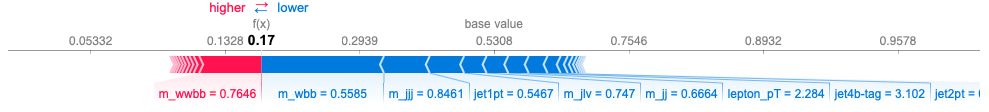

Force plot using 10 events
*****

In [27]:
start=0
end=10
shap.force_plot(explainer.expected_value, shap_values[start:end,:], X_test.iloc[start:end,:], link="logit", show=True)

### Summary Plots
*****

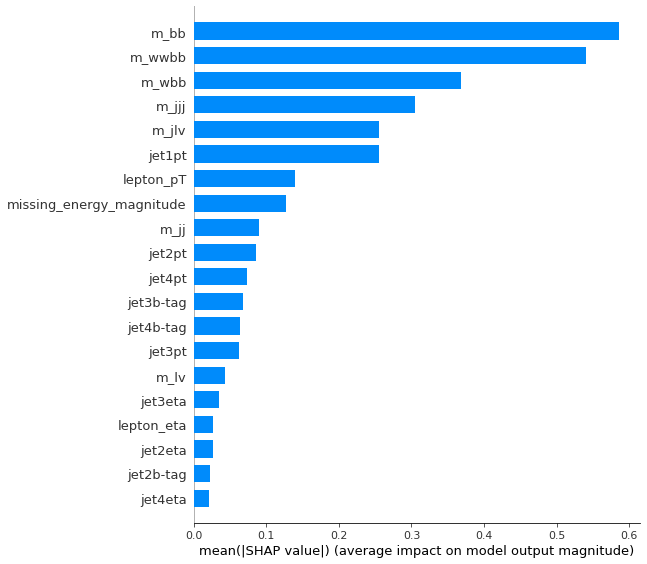

In [28]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

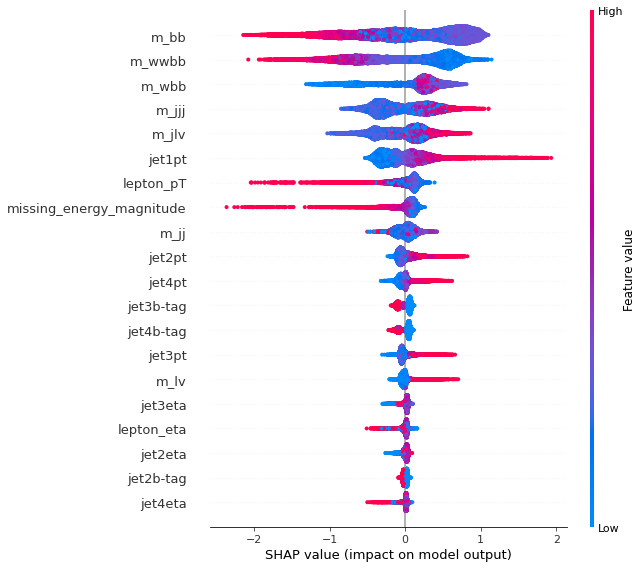

In [29]:
shap.summary_plot(shap_values, X_test)

- The dots of the plot correspond to the data points used to build the explainer (testing data in our case)
- The features are ranked in descending order.
- The $x$ axis shows whether the effect of the SHAP value is associated with a higher or lower prediction.
- The color shows when the feature value is high (in red) or low (in blue) for that particular data point.
-  When “$m_{bb}$” feature value increases, is less likely to predict signal. 

### Dependence Plot
*****
- This plot shows  the effect of a single feature on all predictions made by the model using the SHAP dependence scatter plot.

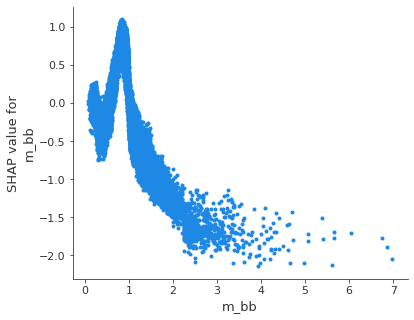

In [30]:
shap.dependence_plot("m_bb", shap_values, X_test, interaction_index=None)

- From the plot above, we observe that when the m_bb increases, the SHAP value for m_bb decreases, which confirms the results of the previous plot.

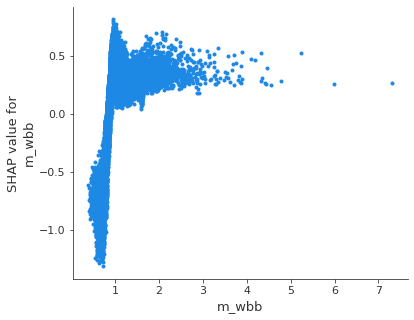

In [31]:
shap.dependence_plot("m_wbb", shap_values, X_test, interaction_index=None)

- From the plot above, we observe that when the m_wbb increases, the SHAP value for m_wbb increases.

*****
#### Interaction with other features
- This plot also shows the interaction between the m_wbb feature with other features
- The plot will attempt to select the feature with the strongest interaction with m_wbb:


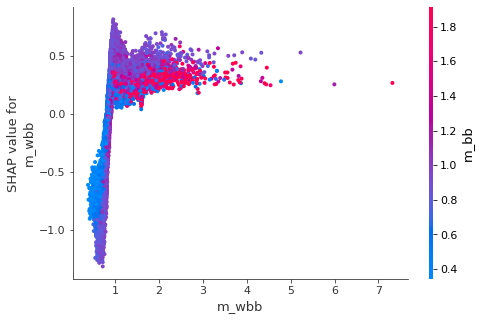

In [32]:
shap.dependence_plot("m_wbb", shap_values,  X_test )

- From the plot below we could say that m_wbb  is strongly related to m_bb
- m_wbb  $\approx 3$ (the dataset has normalized values) and high values of m_bb are more likely to be signal.

More dependence plots:

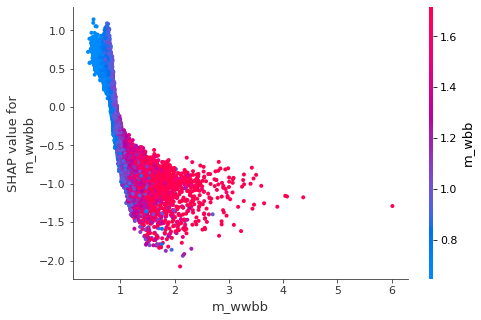

In [33]:
shap.dependence_plot("m_wwbb", shap_values,  X_test )

- From the plot below we could say that m_wwbb  is strongly related to m_wbb
- High values of m_wwbb  (the dataset has normalized values) and high values of m_wbb are more likely to be signal.

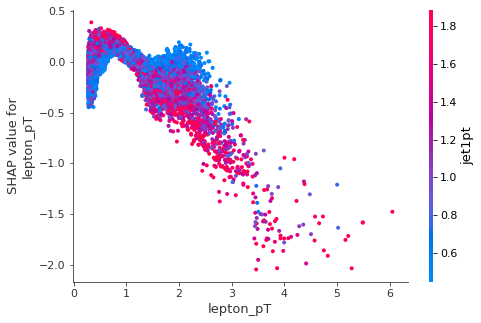

In [34]:
shap.dependence_plot("lepton_pT", shap_values,  X_test )

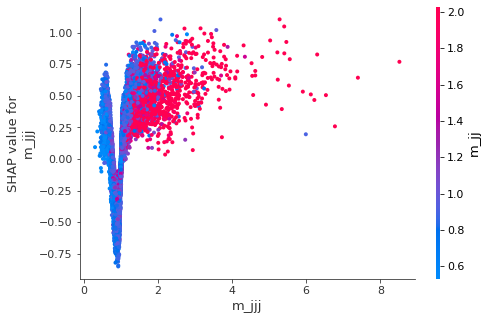

In [35]:
shap.dependence_plot("m_jjj", shap_values,  X_test )

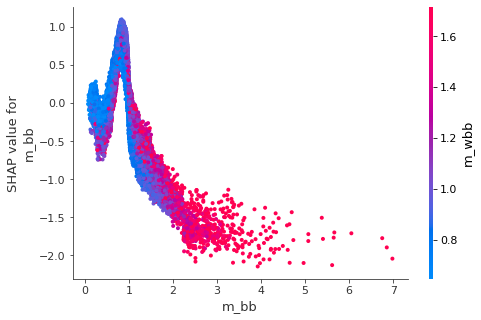

In [36]:
shap.dependence_plot("m_bb", shap_values,  X_test )